In [51]:
from PIL import Image, ImageDraw, ImageFont, ImageFilter, ImageOps
import os
import numpy as np
import re
import random
import asyncio
import aiohttp
import cv2
import json
import matplotlib.pyplot as plt
import time

# Resolutions list

In [52]:
res_16_9 = [(1280,720),(1920,1080),(800,450),(640,360)]
res_191_100 = [(1200,628),(600,314)]
res_2_3 = [(400,600),(300,450),(1000,1500)]
res_1080p = [(1920,1080)]
res_540p = [(960, 540)]
res_720p = [(1280,720)]

# Text samples

In [53]:
loremIpsum = 'Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.'
shakespear = "Shall I compare thee to a summer's day?Thou art more lovely and more temperate:Rough winds do shake the darling buds of May,And summer's lease hath all too short a date:Sometime too hot the eye of heaven shines,And often is his gold complexion dimmed,And every fair from fair sometime declines,By chance, or nature's changing course untrimmed:But thy eternal summer shall not fade,Nor lose possession of that fair thou ow'st,Nor shall death brag thou wander'st in his shade,When in eternal lines to time thou grow'st,So long as men can breathe, or eyes can see,So long lives this, and this gives life to thee."
pulpFictionJules = """And I will strike down upon thee with great vengeance 
and furious anger those who attempt to poison and destroy my brothers. 
And you will know I am the Lord when I lay my vengeance upon you."""
gbuBlondie = "You see in this world there's two kinds of people, my friend - those with loaded guns, and those who dig. You dig."
godfather= "I'm gonna make him an offer he can't refuse."

# Util functions

In [54]:
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

In [55]:
def formatRgbTupleToHex(rgbTupleColor):
    return '#{:02x}{:02x}{:02x}'.format( rgbTupleColor[0],rgbTupleColor[1],rgbTupleColor[2])

In [56]:
def randomColor():
    return tuple(np.random.choice(range(256), size=3))

In [57]:
def randomHexColor():
    c = "#"+"%03x" % random.randint(0, 0xFFFFFF)
    while (len(c) != 7):
        c = "#"+"%03x" % random.randint(0, 0xFFFFFF)
    return c

In [58]:
def createFolder(dirName):
    if not os.path.exists(dirName):
        os.makedirs(dirName)

In [59]:
def removeAllImages():
    for file in os.listdir('images'):
        os.remove('images/' + file)

In [60]:
def saveToFile(img, splitIntoFolders, fontSize, fontType, res, indexer, fileNamePrefix = '',):
    if (splitIntoFolders):
        path = os.path.join('images/', fontType, str(fontSize))
        createFolder(path)   
        img.save(os.path.join(path, fileNamePrefix + '-'.join([str(fontSize)+"pt",'x'.join(map(str, res)), str(indexer)])) + '.png')
    else:
        dirPath = os.path.join('images')
        createFolder(dirPath)   
        filePath = os.path.join(dirPath, fileNamePrefix + '-'.join([str(fontSize)+"pt", 'x'.join(map(str, res)), str(indexer)]) + '.png')
        img.save(filePath)

In [61]:
def get_hex_code(color):
    result = re.match(r'^#?([a-f0-9]{3,3}|[a-f0-9]{6,6})$', color)
    
    if result is None:
        raise Exception('Could not extract color')
        
    result = list(result.group(1))

    if len(result) == 6:
        result = [result[i] + result[i+1] for i in range(0, len(result), 2)]
    else:
        result = [result[i] + result[i] for i in range(0, len(result))]
        
    return [int(hex_code, 16) for hex_code in result]

In [62]:
def calculate_luminace(color_code):
    index = float(color_code) / 255 

    if index < 0.03928:
        return index / 12.92
    else:
        return ( ( index + 0.055 ) / 1.055 ) ** 2.4
    

In [63]:
def calculate_relative_luminance(rgb):
    return 0.2126 * calculate_luminace(rgb[0]) + 0.7152 * calculate_luminace(rgb[1]) + 0.0722 * calculate_luminace(rgb[2]) 


In [64]:
def hexColorContrast(color1, color2):
    #print("Color1: %s Color2: %s" % (color1, color2))
    color_one = get_hex_code(color1)
    color_two = get_hex_code(color2)

    col_lum_1 = calculate_relative_luminance(color_one)
    col_lum_2 = calculate_relative_luminance(color_two)
    
    if (col_lum_1 > col_lum_2):
        light = col_lum_1
        dark = col_lum_2
    else:
        light = col_lum_2
        dark = col_lum_1

    contrast_ratio = (light + 0.05) / (dark + 0.05);
    
    #print("Contrast: %s, Light luminance: %s, Dark luminance: %s" % (contrast_ratio, light + 0.05, dark + 0.05))
    if contrast_ratio < 3:
        usable_for = "Below 3"
    elif contrast_ratio >= 3 and contrast_ratio < 4.5:
        usable_for = "Between 3 and 4.5"
    elif contrast_ratio >= 4.5 and contrast_ratio < 7:
        usable_for = "AA level"
    elif contrast_ratio >= 7:
        usable_for = "AAA level"

    return contrast_ratio

In [65]:
def prepareNamePrefix(func, colors):
    bgContrast = colors[3]
    txtBgContrast1 = colors[4]
    txtBgContrast2 = colors[5]

    colorHex = colors[6]
    secondColorHex = colors[7]
    txtColorHex = colors[8]
    
    if (not(func == twoColoredRectangleBackground or func == twoColoredHorizontalRectangleBackground)):   
        secondColorHex = colorHex
        txtBgContrast2 = txtBgContrast1
    
    return "bgContrast_%s_txtToBg1_%s_txtToBg2_%s_c1_%s_c2_%s_tc_%s_" % (
                                                                           "",#"{:.2f}".format(bgContrast), 
                                                                           "{:.2f}".format(txtBgContrast1), 
                                                                           "",#"{:.2f}".format(txtBgContrast2), 
                                                                           colorHex.lstrip('#'), 
                                                                           "",#secondColorHex.lstrip('#'), 
                                                                           txtColorHex.lstrip('#'))

In [66]:
def rgb_difference(c):
    return abs(c[0] - c[1]) + abs(c[1] - c[2])

In [67]:
def getColorsOfGivenContrast(bgColorsMaxContrast=3, bgToTxtMinContrast=7.0, c1=None, c2=None, c3=None, soft_diff = 70):
    
    color = randomColor() if c1 is None else c1
    secondColor = randomColor() if c2 is None else c2
    textColor = randomColor() if c3 is None else c3

    colorHex = formatRgbTupleToHex(color)
    secondColorHex = formatRgbTupleToHex(secondColor)
    textColorHex = formatRgbTupleToHex(textColor)

    backgroundContrast = hexColorContrast(colorHex, secondColorHex)
    textToBackgroundContrast1 = hexColorContrast(textColorHex, colorHex)
    textToBackgroundContrast2 = hexColorContrast(textColorHex, secondColorHex)

    if c1 is not None and c2 is not None and c3 is not None:
        return (color, secondColor, textColor, backgroundContrast, textToBackgroundContrast1, textToBackgroundContrast2, colorHex, secondColorHex, textColorHex)
    
    timeout = 10   # [seconds]
    timeout_start = time.time()
    
    while(rgb_difference(color) > soft_diff or rgb_difference(textColor) > soft_diff or not(backgroundContrast < bgColorsMaxContrast and textToBackgroundContrast1 > bgToTxtMinContrast and textToBackgroundContrast2 > bgToTxtMinContrast)):
        if time.time() >= timeout_start + timeout:
            print("color finding timeout")
            break
        if c1 is None:
            color = randomColor() 
            colorHex = formatRgbTupleToHex(color)
        if c2 is None:
            secondColor = randomColor() 
            secondColorHex = formatRgbTupleToHex(secondColor)
        if c3 is None:
            textColor = randomColor() 
            textColorHex = formatRgbTupleToHex(textColor)
        
        backgroundContrast = hexColorContrast(colorHex, secondColorHex)
        textToBackgroundContrast1 = hexColorContrast(textColorHex, colorHex)
        textToBackgroundContrast2 = hexColorContrast(textColorHex, secondColorHex)
        
        
        
    return (color, secondColor, textColor, backgroundContrast, textToBackgroundContrast1, textToBackgroundContrast2, colorHex, secondColorHex, textColorHex)

In [68]:
async def get_random_photo_background(shape):
    url = f'https://picsum.photos/{shape[1]}/{shape[0]}'
    async with aiohttp.ClientSession() as session, session.get(url=url) as response:
        resp = await response.read()
        image_array = np.asarray(bytearray(resp), dtype='uint8')
        image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
        return image

In [69]:
def clean_font_name(font_name):
    font_name = font_name.removesuffix("\n")
    font_name = font_name.removesuffix("*")
    font_name = re.sub("\(.*","", font_name)
    font_name = font_name.lower()
    return font_name

In [70]:
def find_coeffs(original_coords, warped_coords):
        matrix = []
        for p1, p2 in zip(original_coords, warped_coords):
            matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
            matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])

        A = np.matrix(matrix)
        B = np.array(warped_coords).reshape(8)

        res = np.dot(np.linalg.inv(A.T * A) * A.T, B)
        return np.array(res).reshape(8)

In [71]:
def visualizeColors(c1, c2, c3):
    fig,ax = plt.subplots(1,3)
    im1 = Image.new('RGB', (100,100), c1)
    im2 = Image.new('RGB', (100,100), c2)
    im3 = Image.new('RGB', (100,100), c3)
    
    ax[0].axis('off')
    ax[0].set_title('primary')
    ax[0].imshow(im1)
    
    ax[1].imshow(im2)
    ax[1].axis('off')
    ax[1].set_title('secondary')
    
    ax[2].imshow(im3)
    ax[2].axis('off')
    ax[2].set_title('text')

# Base of the image, background functions

In [72]:
def simpleBackground(size, color, mode='RGB'):
    return Image.new(mode, size, color)

In [73]:
#it will generate background, half colored with given color parameter, half with random one
def twoColoredRectangleBackground(size, color, secondColor=randomColor(), mode='RGB'):
    img = Image.new(mode, size, color)
    draw = ImageDraw.Draw(img)
    draw.rectangle((int(size[0]/2),size[1],size[0],0), fill=secondColor)
    return img.copy()

In [74]:
def twoColoredHorizontalRectangleBackground(size, color, secondColor=randomColor(), mode='RGB'):
    img = Image.new(mode, size, color)
    draw = ImageDraw.Draw(img)
    draw.rectangle((0, int(size[1]/2), size[0], size[1]), fill=secondColor)
    return img.copy()

In [75]:
def multiColoredRectangleBackground(size, color, mode='RGB'):
    img = Image.new(mode, size, color)
    draw = ImageDraw.Draw(img)
    for i in range(1,6):
        draw.rectangle((int(size[0]/5)*i,size[1],size[0],0), fill=randomColor())
    return img.copy()

In [76]:
#it will generate background, half colored with given color parameter diagonally, half with random one
def twoColoredPolygonBackground(size, color, mode='RGB'):
    img = Image.new(mode, size, color)
    draw = ImageDraw.Draw(img)
    draw.polygon([(0,0),(size[0],size[1]),(size[0],0)], fill=randomColor())
    return img.copy()

In [77]:
#it will generate background, half colored with given color parameter diagonally, half with random one
def twoColoredInvertedPolygonBackground(size, color, mode='RGB'):
    img = Image.new(mode, size, color)
    draw = ImageDraw.Draw(img)
    draw.polygon([(size[0],0),(size[0],size[1]),(0,size[1])], fill=randomColor())
    return img.copy()

In [78]:
async def photoBackground(size):
    img = await get_random_photo_background(size)
    return Image.fromarray(img)

# Random triangles and circles

In [79]:
def addRandomCircles(img):
    circleMaxSize = np.random.choice(range(5,450))
    circleNumber = np.random.choice(range(30, 300))
    draw = ImageDraw.Draw(img)
    for i in range(1, circleNumber):
        x1 = np.random.choice(range(img.size[0]))
        y1 = np.random.choice(range(img.size[1]))
        circSize = np.random.choice(range(int(circleMaxSize)))
        draw.ellipse((x1, y1, x1+circSize, y1+circSize), fill = randomColor())
    return img.copy()

In [80]:
def addRandomTriangles(img):
    triangleMaxSize = np.random.choice(range(15,450))
    triangleNumber = np.random.choice(range(30, 300))
    draw = ImageDraw.Draw(img)
    for i in range(1, triangleNumber):
        try:
            triangleSize = np.random.choice(range(triangleMaxSize))
            while(triangleSize == 1 or triangleSize == 0):
                triangleSize = np.random.choice(range(triangleMaxSize))
            
            x0 = np.random.choice(range(img.size[0]))
            y0 = np.random.choice(range(img.size[1]))
        
            x1 = x0 + np.random.choice(range(int(-0.5*triangleSize), int(0.5*triangleSize)))
            x2 = x0 + np.random.choice(range(int(-0.5*triangleSize), int(0.5*triangleSize)))
            x3 = x0 + np.random.choice(range(int(-0.5*triangleSize), int(0.5*triangleSize)))
        
            y1 = y0 + np.random.choice(range(int(-0.5*triangleSize), int(0.5*triangleSize)))
            y2 = y0 + np.random.choice(range(int(-0.5*triangleSize), int(0.5*triangleSize)))
            y3 = y0 + np.random.choice(range(int(-0.5*triangleSize), int(0.5*triangleSize)))
        except:
            pass
        
        draw.polygon([(x1,y1),(x2,y2),(x3,y3)], fill = randomColor())
    return img.copy()

# Image modification

In [81]:
def blurImage(img, gausRad = 2):
    img = img.filter(ImageFilter.GaussianBlur(gausRad))
    return img.copy()

# Generating and adding text

In [82]:
small_letters = "weruoaszxcvnm"
big_up_letters = "tidfhklb"
big_down_letters = "qypgj"

In [117]:
def get_small_text(capitalize = False, words_count = 5):
    text = ""
    for i in range(words_count):
        for k in range(np.random.choice(range(1,7))):
            text+= np.random.choice(list(small_letters))
        text+= " "
    return text.capitalize() if capitalize else text

In [118]:
def get_big_up_text(capitalize = False, words_count = 5):
    text = ""
    for i in range(words_count):
        for k in range(np.random.choice(range(1,7))):
            text+= np.random.choice(list(big_up_letters))
        text+= " "
    return text.capitalize() if capitalize else text

In [119]:
def get_big_down_text(capitalize = False, words_count = 5):
    text = ""
    for i in range(words_count):
        for k in range(np.random.choice(range(1,7))):
            text+= np.random.choice(list(big_down_letters))
        text += " "
    return text.capitalize() if capitalize else text

In [86]:
with open("./slogan_dict.json", "r") as fp:
    slogans = json.load(fp)

In [87]:
def getText(sourceText = shakespear, line_breaks = 0):
    spacesList = [pos for pos, char in enumerate(sourceText) if char == ' ']
    replace = len(spacesList) < line_breaks
    for space_pos in np.random.choice(spacesList, line_breaks, replace=replace):
        sourceText = sourceText[:space_pos] + "\n" + sourceText[space_pos+1:]
    return sourceText

In [88]:
def addText(img, sourceText = getText(), randomize = False ,color=(0,0,0), fontSize=15, fontType='arial.ttf'):
    draw = ImageDraw.Draw(img)
    #fontSize in point (pt)
    font = ImageFont.truetype(fontType, fontSize)

    if(randomize):
        x = np.random.choice(range(img.size[0]-50))
        y = np.random.choice(range(img.size[1]-50))
        spacesList = [pos for pos, char in enumerate(sourceText) if char == ' ']
        r2 = np.random.choice(spacesList)
        del spacesList[spacesList.index(r2)]
        r1 = np.random.choice(spacesList)
        del spacesList[spacesList.index(r1)]
        r3 = np.random.choice(spacesList)
        del spacesList[spacesList.index(r3)]
        r4 = np.random.choice(spacesList)

        r = [r1,r2,r3,r4]
        sorted(r)
        text = sourceText[r[0]:r[1]] +"\n"+ sourceText[r[1]:r[2]] + "\n" + sourceText[r[2]:r[3]]
    else:
        x = 40
        y = int(img.size[1]/2) - int(font.size/1.5)
        text = sourceText
    
    draw.text((x,y), text, fill=color, font=font)
    return img.copy()

In [89]:
def get_random_slogan():
    return np.random.choice(list(slogans['Apparel']['Beachwear & swimwear'].values()))

In [90]:
def addRotatedText(img, angle=0, random_position=False, perspective=False, sourceText=shakespear, color=(0,0,0), fontSize=15, fontType='arial.ttf'):
    draw = ImageDraw.Draw(img)
    #fontSize in point (pt)
    font = ImageFont.truetype(fontType, fontSize)

    x = np.random.choice(range(int(img.size[0]/2)-50))
    y = np.random.choice(range(int(img.size[1]*0.75)-50))
    
    f = ImageFont.truetype(fontType, fontSize)
    txt=Image.new('L', f.getsize(sourceText))
    d = ImageDraw.Draw(txt)
    d.text( (0, 0), str(sourceText),  font=f, fill=255)
    w=txt.rotate(angle,  expand=1)
    if perspective:
        w = add_perspective(w)

    if random_position:
        img.paste( ImageOps.colorize(w, (0,0,0), color), (x,y),  w)
    else:
        img.paste( ImageOps.colorize(w, (0,0,0), color), (int(img.size[0]*0.10),int(img.size[1]*0.2)),  w)
    
    return img.copy()

# Available fonts

In [91]:
arialGeo = 'fonts/Arial_GEO.TTF'
arialNarrow = 'fonts/Arialn.ttf'
arialNarrowBold = 'fonts/Arialnb.ttf'
arialBlackMegaBold = 'fonts/ariblk.ttf'
arialGeoItallic = 'fonts/G_ari_i.TTF'

timesNewRoman = 'fonts/times_new_roman.ttf'
timesNewRomanItalic = 'fonts/times_new_roman_italic.ttf'
timesNewRomanBold = 'fonts/times_new_roman_bold.ttf'

verdana = 'fonts/verdana.ttf'
verdanaItalic = 'fonts/verdana_italic.ttf'
verdanaBold = 'fonts/verdana_bold.ttf'

In [92]:
with open("./serif_wiki_list.txt", "r") as f:
    serif_list = f.readlines()

with open("./nonserif_wiki_list.txt", "r") as f:
    nonserif_list = f.readlines()

big_pile_of_fonts =[os.path.join("./fonts", x).lower() for x in os.listdir("./fonts")]  

clean_serif_wiki_list = [clean_font_name(x) for x in serif_list]
clean_nonserif_wiki_list = [clean_font_name(x) for x in nonserif_list]

In [93]:
serif_fonts = []
nonserif_fonts = []
font_dict = {}
for stripped_font, font in [(re.match(r'./fonts\\(.*)\.', x).groups()[0], x) for x in big_pile_of_fonts]:
    font_dict[stripped_font] = font
    if stripped_font in clean_serif_wiki_list:
        serif_fonts.append(font)
    if stripped_font in clean_nonserif_wiki_list:
        nonserif_fonts.append(font)
                

In [94]:
def get_font_wildcard(wildcard):
    re_filter = re.compile(".*" + wildcard + ".*")
    return list(filter(re_filter.match, font_dict.keys()))
get_font_wildcard("caslon")

['acaslonpro-bold',
 'acaslonpro-bolditalic',
 'acaslonpro-italic',
 'acaslonpro-regular',
 'acaslonpro-semibold',
 'acaslonpro-semibolditalic']

In [95]:
for serif_font in clean_serif_wiki_list:
    sf = ([font_dict[x] for x in get_font_wildcard(serif_font)])
    if len(sf) > 0:
        serif_fonts += sf

In [96]:
for sanserif_font in clean_nonserif_wiki_list:
    sf = ([font_dict[x] for x in get_font_wildcard(sanserif_font)])
    if len(sf) > 0:
        nonserif_fonts += sf

In [97]:
nonserif_fonts

['./fonts\\arial.ttf',
 './fonts\\calibri.ttf',
 './fonts\\corbel.ttf',
 './fonts\\eurostile.ttf',
 './fonts\\helvetica.ttf',
 './fonts\\impact.ttf',
 './fonts\\tahoma.ttf',
 './fonts\\verdana.ttf',
 './fonts\\arial.ttf',
 './fonts\\arialbd.ttf',
 './fonts\\arialbd_0.ttf',
 './fonts\\arialbi.ttf',
 './fonts\\arialce.ttf',
 './fonts\\arialcebold.ttf',
 './fonts\\arialcebolditalic.ttf',
 './fonts\\arialceitalic.ttf',
 './fonts\\arialcemtblack.ttf',
 './fonts\\ariali.ttf',
 './fonts\\arialn.ttf',
 './fonts\\arialnb.ttf',
 './fonts\\arialnbi.ttf',
 './fonts\\arialni.ttf',
 './fonts\\arialth.ttf',
 './fonts\\arialunicodems.ttf',
 './fonts\\arial_geo.ttf',
 './fonts\\bauhaus-93.ttf',
 './fonts\\calibri.ttf',
 './fonts\\calibrib.ttf',
 './fonts\\calibrii.ttf',
 './fonts\\calibril.ttf',
 './fonts\\calibrili.ttf',
 './fonts\\calibriz.ttf',
 './fonts\\corbel.ttf',
 './fonts\\corbelb.ttf',
 './fonts\\corbelb_0.ttf',
 './fonts\\corbeli.ttf',
 './fonts\\corbeli_0.ttf',
 './fonts\\corbell.ttf',
 './

In [98]:
serif_fonts

['./fonts\\cambria.ttc',
 './fonts\\centaur.ttf',
 './fonts\\georgia.ttf',
 './fonts\\jokerman.ttf',
 './fonts\\playbill.ttf',
 './fonts\\sylfaen.ttf',
 './fonts\\arnorg_.ttf',
 './fonts\\cambria.ttc',
 './fonts\\cambriab.ttf',
 './fonts\\cambriai.ttf',
 './fonts\\cambriaz.ttf',
 './fonts\\acaslonpro-bold.otf',
 './fonts\\acaslonpro-bolditalic.otf',
 './fonts\\acaslonpro-italic.otf',
 './fonts\\acaslonpro-regular.otf',
 './fonts\\acaslonpro-semibold.otf',
 './fonts\\acaslonpro-semibolditalic.otf',
 './fonts\\wyldb.ttf',
 './fonts\\wyldt.ttf',
 './fonts\\centaur.ttf',
 './fonts\\agaramondpro-bold.otf',
 './fonts\\agaramondpro-bolditalic.otf',
 './fonts\\agaramondpro-italic.otf',
 './fonts\\agaramondpro-regular.otf',
 './fonts\\georgia.ttf',
 './fonts\\georgiab.ttf',
 './fonts\\georgiai.ttf',
 './fonts\\georgiaz.ttf',
 './fonts\\jokerman.ttf',
 './fonts\\minionpro-bold.otf',
 './fonts\\minionpro-boldcn.otf',
 './fonts\\minionpro-boldcnit.otf',
 './fonts\\minionpro-boldit.otf',
 './fonts\

((38, 16, 254), (66, 131, 54), (246, 229, 110), 1.7511575933732413, 6.31895677254591, 3.6084455199567462, '#2610fe', '#428336', '#f6e56e')


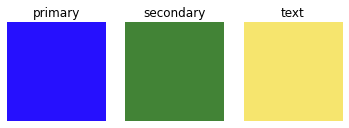

In [99]:
colors = getColorsOfGivenContrast(3,3,soft_diff = 999999)
c1 = colors[0]
c2 = colors[1]
c3 = colors[2]
print(colors)
visualizeColors(c1, c2, c3)

# Main function

In [100]:
getColorsOfGivenContrast(c1=(230,230,230), bgColorsMaxContrast=21, bgToTxtMinContrast=7, soft_diff=70)

((230, 230, 230),
 (79, 222, 10),
 (3, 2, 20),
 1.4277016912616691,
 16.453187775503707,
 11.524247590520062,
 '#e6e6e6',
 '#4fde0a',
 '#030214')

In [134]:
#backgroundFunc - function that will generate background image
#resList - list of resolution of images that will be generated
#repetition - how many images are generated for given resolution
#name addition - prefix added for each generated file

async def generateImagesText(backgroundFunc, fontTypeList, resList, fontSizeList, repetition, fileNamePrefix, splitIntoFolders = True, colors = [None,None,None]):
    indexer = 1
    for func in backgroundFunc:
        for fontType in fontTypeList:
            for res in resList:
                for fntSize in fontSizeList:
                    for i in range(1, repetition+1):
                        try:
                            #fontSize = np.random.choice(range(10, 50))
                            fontSize = fntSize
                            blurLevel = np.random.choice(range(0,30))
                            blurLevel = 142

                            colors = getColorsOfGivenContrast(c1=colors[0], c2=colors[1], c3=colors[2], bgColorsMaxContrast=21, bgToTxtMinContrast = 7, soft_diff=70)
                            #colors = getColorsOfGivenContrast(bgColorsMaxContrast=5, bgToTxtMinContrast= 7.5)
                            color = colors[0]
                            secondColor = colors[1]
                            txtColor = colors[2]
                            #print(colors)

                            if func == twoColoredRectangleBackground or func == twoColoredHorizontalRectangleBackground:
                                img = func(res, color, secondColor)
                            elif func == photoBackground:
                                img = await func(res)
                            else:
                                img = func(res, color)

                            font_clean_name = re.match(r'./fonts\\(.*)\.', fontType).groups()[0]
                            namePrefix = str(indexer) + " " + font_clean_name

                            #img = addRandomCircles(img)
                            #img = addRandomTriangles(img)
                            #img = blurImage(img, gausRad = blurLevel)

                            #sourceText = godfather
                            #sourceText = getText(sourceText = get_random_slogan(), line_breaks= 0)
                            sourceText = get_big_down_text()
                            #sourceText = getText(sourceText = godfather, line_breaks= 0)
                            #sourceText = ""
                            
                            rotation_angle = 0
                            add_perspective = False
                            img = addRotatedText(img, sourceText=sourceText, angle=rotation_angle, perspective=add_perspective, color=txtColor, fontSize=fontSize, fontType=fontType)

                            #saveToFile(img=img, splitIntoFolders=splitIntoFolders, 
                            #           fileNamePrefix=namePrefix, 
                            #           fontSize=fontSize,
                            #           fontType=fontType,
                            #           res=res, indexer=indexer)
                            
                            filePath = os.path.join("./images", namePrefix + '.png')
                            img.save(filePath)
                            
                            
                            indexer +=1
                        except:
                            print("Could not generate", fontType)

# Pick your parameters
### Comment out background functions, fonts, that you don't want to have generated
### Pick resolutions, you can pick existing list (see list on the top) or enter it in format [(height,width)]

In [137]:
backgroundFunctions = [    
    #simpleBackground,     
    twoColoredRectangleBackground,   
    twoColoredHorizontalRectangleBackground,   
    #twoColoredPolygonBackground, 
    #twoColoredInvertedPolygonBackground, 
    #multiColoredRectangleBackground,
    #photoBackground
]

In [136]:
removeAllImages()
resList = res_540p
fontSizeList = [45]
repetition = 1
#fontsList = [timesNewRoman,timesNewRomanItalic, timesNewRomanBold, verdana, verdanaItalic, verdanaBold, arialGeoItallic, arialNarrow, arialNarrowBold, arialBlackMegaBold]
#fontsList = big_pile_of_fonts
#fontsList = nonserif_fonts
#fontsList = serif_fonts
#fontsList = [font_dict['impact']]
#fontsList = [font_dict["acaslonpro-bold"]]
colors = getColorsOfGivenContrast(c1=(230,230,230))[0:3]
await generateImagesText(backgroundFunctions, 
                         fontTypeList=fontsList, 
                         resList=resList, 
                         fontSizeList = fontSizeList, 
                         repetition = repetition, 
                         fileNamePrefix='', 
                         splitIntoFolders=False,
                         colors = colors)

Could not generate ./fonts\fms_metadata.xml


In [ ]:
#Just for information purposes
n = len(backgroundFunctions) * len(fontsList) * len(resList) * len(fontSizeList) * repetition
print("Number of images that will be generated: " + str(n))

In [ ]:
im_path = np.random.choice(os.listdir("./images"))
img = Image.open(os.path.join('./images/', im_path))

In [ ]:
with open("big_fonts_pile.txt", "w") as f:
    f.write(json.dumps(big_pile_of_fonts))

In [ ]:
def add_perspective(img, x=50, y=0):
    
    width, height = img.size
    m = -85*0.01
    n = 8*0.01
    xshift = m * width 
    yshift = n * height
    new_width = width + int(round(abs(xshift)))
    new_height = height + int(round(abs(yshift)))
    
    #coeffs = find_coeffs(
    #    [(0, 0), (width, 0), (width, height), (0, height)],
    #    [(xshift if xshift <= 0 else 0, yshift if yshift <= 0 else 0), (new_width, 0), (new_width + xshift if xshift > 0 else new_width, new_height - yshift if yshift <= 0 else new_height), (0, new_height)])
    
    coeffs = find_coeffs(
        [(0, 0), (width, 0), (width, height), (0, height)],
        [(0, 0), (new_width, 0), (new_width, new_height), (xshift, height)])
    
    return img.transform((new_width, new_height), Image.PERSPECTIVE, coeffs, Image.BICUBIC)


In [ ]:
import ipywidgets as widgets
from IPython.display import clear_output
from IPython.display import display

int_range1 = widgets.IntSlider(min=-100, max=100, continuous_update = False)
int_range2 = widgets.IntSlider(min=-100, max=100, continuous_update = False)

output2 = widgets.Output()

display(int_range1, int_range2, output2)
def on_value_change(change):
    with output2:
        clear_output(wait=True)
        display(add_perspective(img, int_range1.value, int_range2.value))
        
        #print(change['new'])

int_range1.observe(on_value_change, names='value')
int_range2.observe(on_value_change, names='value')